/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


{'data_root': '/media/julian/Maxtor/DATA/cmu_panoptic',
 'nodes': [1, 15, 3, 13, 8],
 'panels': [1, 6, 14, 18, 5],
 'seq_name': '160422_ultimatum1'}
step 1: elapsed 1.3492658138275146
step 2: elapsed 0.023294448852539062
step 3: elapsed 0.746187686920166
-------------------------------------------
Handle transitivity:
	Intra:		 802
	Intra(choice):	 13
	Inter:		 6535
	Inter(choice):	 472
-------------------------------------------
	Time =  26245  ms
	result: 0

	Total cost: 853.3399372096269

# valid points:		 184
# invalid points:	 24
step 4: elapsed 26.281655311584473
step 5: elapsed 0.02043771743774414

total elapsed: 28.422825574874878


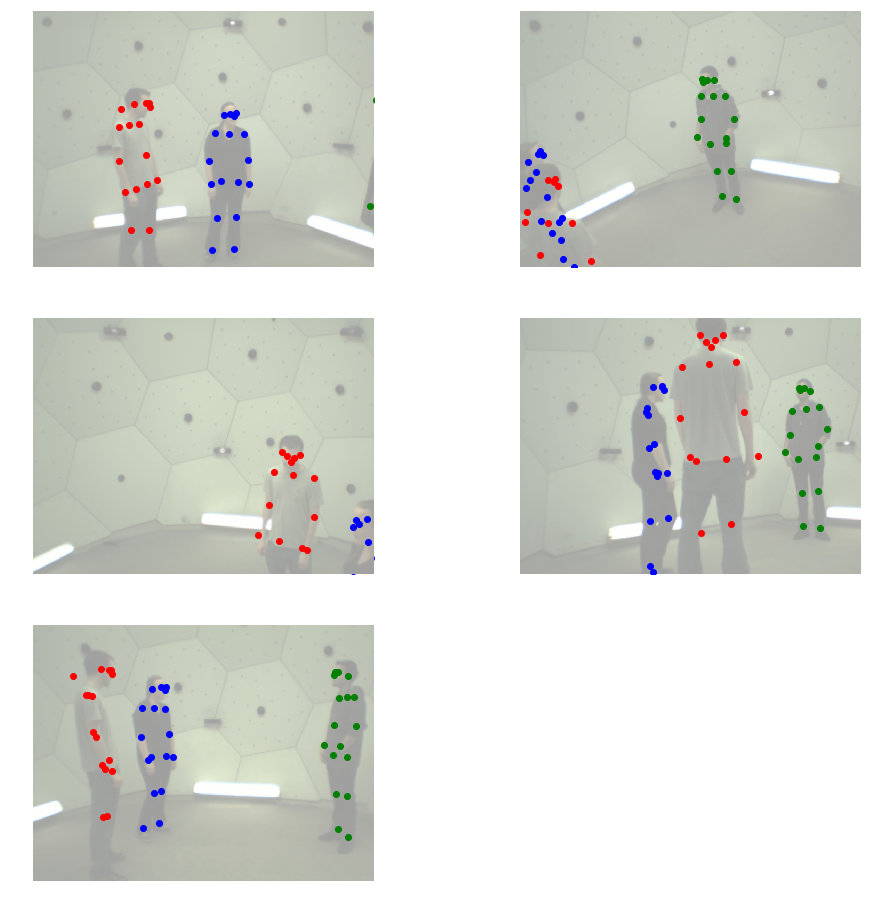

In [1]:
%matplotlib inline
# ---- settings ----
import json
from pprint import pprint
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time

from mvpose.data import cmu_panoptic

root = Settings['CMU']['data_root']

pprint(Settings['CMU'])
    
FRAME = 2000

panels = Settings['CMU']['panels']
nodes = Settings['CMU']['nodes']

seq_name = Settings['CMU']['seq_name']

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('cmu', Im, FRAME)

# ==================================
from mvpose import pose
from mvpose.algorithm import graphcut
from mvpose.algorithm.settings import get_settings

_start = time()
Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=get_settings(
                                      scale_to_mm=10),
                                  debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)
# ==================================


from mvpose.algorithm.candidate_selection import project_human_to_2d


Humans = detections

fig = plt.figure(figsize=(16,16))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    ax.set_xlim([0, 640])
    ax.set_ylim([480, 0])
    im = Im[idx]
    mapx = cam.mapx
    mapy = cam.mapy
    im = cv2.remap(im, mapx, mapy, interpolation=cv2.INTER_LINEAR)
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[pid])
    
plt.show()